In [15]:
import nltk
import keras
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
import re,string,unicodedata
from bs4 import BeautifulSoup
from string import punctuation
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score,classification_report
from keras.preprocessing import text, sequence
from sklearn.preprocessing import LabelEncoder,LabelBinarizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Embedding, Conv1D, GlobalMaxPooling1D, Concatenate, Dense, Dropout, LayerNormalization,LSTM,Bidirectional,GRU
from tensorflow.keras.models import Model,Sequential
from tensorflow.keras.metrics import AUC
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud,STOPWORDS
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize,sent_tokenize

In [2]:
def strip_html(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()

# Removing the square brackets
def remove_between_square_brackets(text):
    return re.sub('\[[^]]*\]', '', text)

# Removing URL's
def remove_between_square_brackets(text):
    return re.sub(r'http\S+', '', text)

# Removing the stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

# Removing the noisy text
def denoise_text(text):
    text = strip_html(text)
    text = remove_between_square_brackets(text)
    text = remove_stopwords(text)
    return text

In [3]:
# Download NLTK stopwords
nltk.download('stopwords')
stop_words = set(nltk.corpus.stopwords.words('english'))

df_train = pd.read_csv("./dataset/train.csv")
df_test = pd.read_csv("./dataset/test.csv")

[nltk_data] Error loading stopwords: <urlopen error [Errno 11004]
[nltk_data]     getaddrinfo failed>


In [4]:
stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [5]:
# Replace NaN values with an empty string
df_train['text'] = df_train['text'].fillna('')
df_test['text'] = df_test['text'].fillna('')

#Apply function on review column
df_train['text']=df_train['text'].apply(denoise_text)
df_test['text']=df_test['text'].apply(denoise_text)

C:\Users\ROG\AppData\Local\Temp\ipykernel_4148\1142668665.py:2: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser")


In [6]:
X_train = df_train['text'] 
y_train = df_train['sentiment']

X_test = df_test['text'] 
y_test= df_test['sentiment']

In [8]:
import gensim.downloader as api

word2vec = api.load("word2vec-google-news-300")

In [9]:
def text_to_word_vectors(text, word2vec):
    tokens = text.split()
    word_vectors = []
    for token in tokens:
        if token in word2vec:
            word_vectors.append(word2vec[token])
            
    if word_vectors:
        text_vector = np.mean(word_vectors, axis=0)  
    else:
        text_vector = np.zeros(word2vec.vector_size)
    return text_vector

train_text_vectors = []
test_text_vectors=[]

for text in df_train['text']:
    text_vector = text_to_word_vectors(text, word2vec)
    train_text_vectors.append(text_vector)

for text in df_test['text']:
    text_vector = text_to_word_vectors(text, word2vec)
    test_text_vectors.append(text_vector)

train_text_vectors_array = np.array(train_text_vectors)
test_text_vectors_array = np.array(test_text_vectors)
print('The shape of the train vector:',train_text_vectors_array.shape)
print('The shape of the test vector:',test_text_vectors_array.shape)

The shape of the train vector: (27481, 300)
The shape of the test vector: (3534, 300)


In [10]:
unique_words = set()

for text in df_train['text']:
    # Tokenize the text into words
    words = text.split()
    # Add unique words to the set
    unique_words.update(words)

vocab_size = len(unique_words)

print("Vocabulary size:", vocab_size)

vocab_size = train_text_vectors_array.shape[0]

Vocabulary size: 50662


In [16]:
num_heads = 6
embedding_dim = 300

class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}")
        self.projection_dim = embed_dim // num_heads
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs) 
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)  
        query = self.separate_heads(query, batch_size) 
        key = self.separate_heads(key, batch_size)  
        value = self.separate_heads(value, batch_size)  
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        output = self.combine_heads(concat_attention)
        return output

max_seq_length = train_text_vectors_array.shape[1]  
input_layer = tf.keras.layers.Input(shape=(max_seq_length,))
multi_head_attention = MultiHeadSelfAttention(embed_dim=embedding_dim, num_heads=num_heads)(input_layer)
cnn_layers = []

filter_sizes = [3, 4, 5]

for filter_size in filter_sizes:
    conv_layer = Conv1D(filters=128, kernel_size=filter_size, activation='relu', padding='same')(multi_head_attention)
    pool_layer = GlobalMaxPooling1D()(conv_layer)
    cnn_layers.append(pool_layer)
    
cnn_output = Concatenate()(cnn_layers)
dropout = Dropout(0.5)(cnn_output)
norm = LayerNormalization()(dropout)
output = Dense(3, activation='softmax')(norm)

model = Model(inputs=input_layer, outputs=output)

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 300)]                0         []                            
                                                                                                  
 multi_head_self_attention   (None, None, 300)            361200    ['input_1[0][0]']             
 (MultiHeadSelfAttention)                                                                         
                                                                                                  
 conv1d (Conv1D)             (None, None, 128)            115328    ['multi_head_self_attention[0]
                                                                    [0]']                         
                                                                                              

In [17]:
le = LabelEncoder()

y_train = le.fit_transform(y_train)
y_train_one_hot = to_categorical(y_train, num_classes=3)

In [18]:
history= model.fit(train_text_vectors_array, y_train_one_hot, validation_split=0.2, epochs=50, batch_size=64)

Epoch 1/50
344/344 [==============================] - 4s 7ms/step - loss: 0.9006 - accuracy: 0.5916 - auc: 0.7721 - val_loss: 0.8548 - val_accuracy: 0.6274 - val_auc: 0.8097
Epoch 2/50
344/344 [==============================] - 2s 7ms/step - loss: 0.8336 - accuracy: 0.6306 - auc: 0.8066 - val_loss: 0.8401 - val_accuracy: 0.6385 - val_auc: 0.8137
Epoch 3/50
344/344 [==============================] - 2s 7ms/step - loss: 0.8145 - accuracy: 0.6421 - auc: 0.8158 - val_loss: 0.8366 - val_accuracy: 0.6422 - val_auc: 0.8171
Epoch 4/50
344/344 [==============================] - 3s 8ms/step - loss: 0.8041 - accuracy: 0.6478 - auc: 0.8207 - val_loss: 0.8365 - val_accuracy: 0.6473 - val_auc: 0.8175
Epoch 5/50
344/344 [==============================] - 3s 9ms/step - loss: 0.7938 - accuracy: 0.6505 - auc: 0.8257 - val_loss: 0.8643 - val_accuracy: 0.6473 - val_auc: 0.8180
Epoch 6/50
344/344 [==============================] - 2s 7ms/step - loss: 0.7855 - accuracy: 0.6533 - auc: 0.8292 - val_loss: 0.87

Epoch 48/50
344/344 [==============================] - 3s 10ms/step - loss: 0.5678 - accuracy: 0.7613 - auc: 0.9128 - val_loss: 1.2298 - val_accuracy: 0.6236 - val_auc: 0.7950
Epoch 49/50
344/344 [==============================] - 3s 9ms/step - loss: 0.5671 - accuracy: 0.7611 - auc: 0.9130 - val_loss: 1.2667 - val_accuracy: 0.6314 - val_auc: 0.7933
Epoch 50/50
344/344 [==============================] - 3s 9ms/step - loss: 0.5610 - accuracy: 0.7651 - auc: 0.9150 - val_loss: 1.2481 - val_accuracy: 0.6289 - val_auc: 0.7920


In [19]:
y_pred = np.argmax(model.predict(test_text_vectors_array), axis=-1)

111/111 [==============================] - 0s 2ms/step


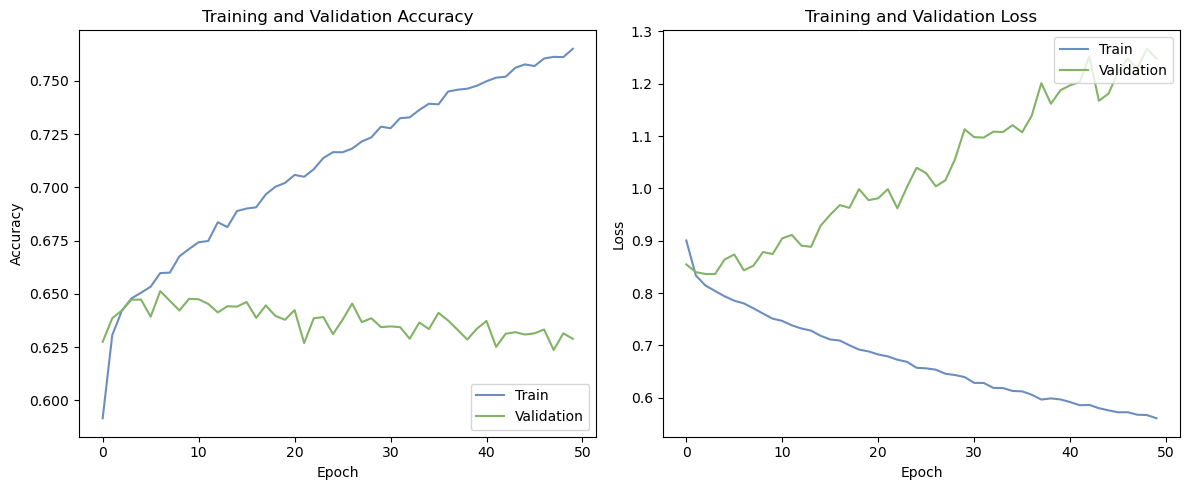

In [21]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy', color='#6c8ebf')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='#82B366')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='lower right')

# Loss curves
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='#6c8ebf')
plt.plot(history.history['val_loss'], label='Validation Loss', color='#82B366')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.tight_layout()
plt.show()

111/111 [==============================] - 0s 2ms/step
ROC-AUC Score: 0.79


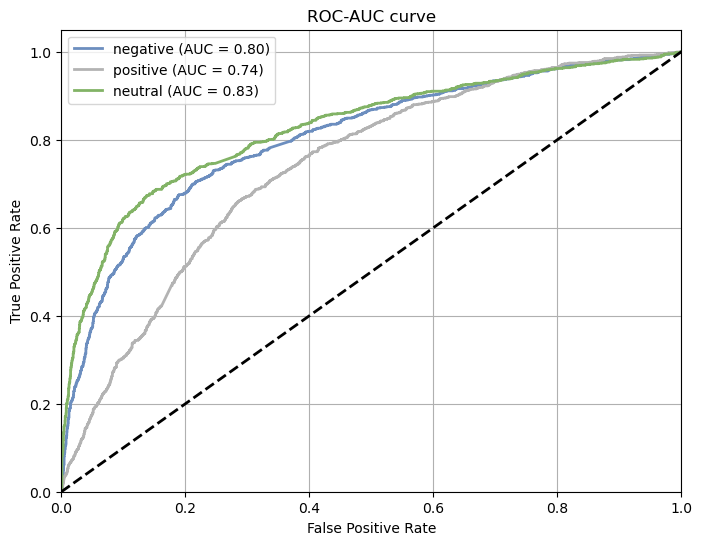

In [23]:
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
from sklearn.metrics import roc_auc_score, roc_curve, auc

if len(y_test.shape) == 1:
    label_binarizer = LabelBinarizer()
    y_test = label_binarizer.fit_transform(y_test)

label_map = {0: 'negative', 1: 'positive', 2: 'neutral'}

y_prob = model.predict(test_text_vectors_array)
roc_auc_ovr = roc_auc_score(y_test, y_prob, multi_class='ovr')

print(f"ROC-AUC Score: {roc_auc_ovr:0.2f}")

n_classes = y_test.shape[1]
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

plt.figure(figsize=(8, 6))

colors = cycle(['#6c8ebf', '#B3B3B3', '#82B366'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='{0} (AUC = {1:0.2f})'.format(label_map[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-AUC curve')
plt.legend(loc="best")
plt.grid(True)
plt.show()

111/111 [==============================] - 0s 2ms/step


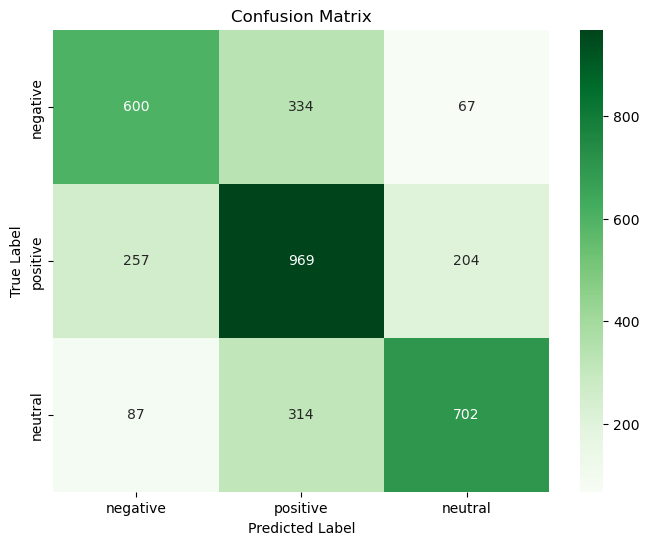

In [24]:
y_pred = np.argmax(model.predict(test_text_vectors_array), axis=1)

conf_matrix = confusion_matrix(np.argmax(y_test, axis=1), y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Greens', 
            xticklabels=[label_map[i] for i in range(n_classes)], 
            yticklabels=[label_map[i] for i in range(n_classes)])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

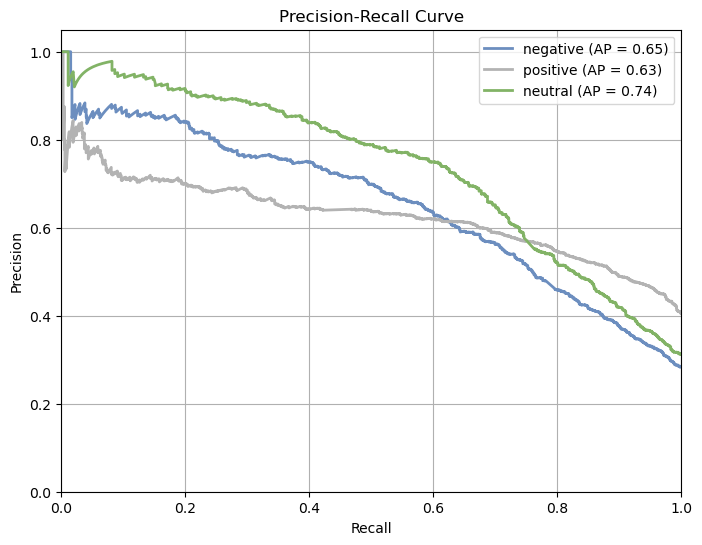

In [25]:
from sklearn.preprocessing import LabelBinarizer
from itertools import cycle
from sklearn.metrics import precision_recall_curve, average_precision_score

precision = dict()
recall = dict()
average_precision = dict()
for i in range(n_classes):
    precision[i], recall[i], _ = precision_recall_curve(y_test[:, i], y_prob[:, i])
    average_precision[i] = average_precision_score(y_test[:, i], y_prob[:, i])

plt.figure(figsize=(8, 6))

colors = cycle(['#6c8ebf', '#B3B3B3', '#82B366'])
for i, color in zip(range(n_classes), colors):
    plt.plot(recall[i], precision[i], color=color, lw=2,
             label='{0} (AP = {1:0.2f})'.format(label_map[i], average_precision[i]))

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend(loc="best")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)
plt.show()

In [32]:
from sklearn.metrics import classification_report

y_pred = np.argmax(model.predict(test_text_vectors_array), axis=1)
print(classification_report(np.argmax(y_test, axis=1), y_pred))

111/111 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.64      0.60      0.62      1001
           1       0.60      0.68      0.64      1430
           2       0.72      0.64      0.68      1103

    accuracy                           0.64      3534
   macro avg       0.65      0.64      0.64      3534
weighted avg       0.65      0.64      0.64      3534

